# Quafing example workflow

This notebook demonstrates the use of quafing on the basis of an example workflow analysing quesstionaire data about subaks.


This notebook assumes that it being executed from `quafing/notebooks/`, i.e. that `quafing/quafing/` is at the same directory hierarchy level, with aa shared parent directory. Before beginning we change the working directory to this common parent directory

In [1]:
import os
os.chdir('../')
print(os.getcwd())

/Users/eslt0101/Projects/REPOS/eScience/SDCCA/QUAFING


We 

In [2]:
import quafing as q

In [3]:
filepath ='/Users/eslt0101/Projects/SABM/FINE_Code/code/data/omri_subak_data.xlsx'


In [4]:
rawmetadata,rawdata = q.load(filepath)

In [5]:
prep = q.PreProcessor(rawdata,rawmetadata)

In [6]:
prep.select_columns(cols=['e'],deselect=True)

In [7]:
prep.set_cont_disc()

In [8]:
prep.set_density_method(method='Discrete1D',cols=['o','u','b'])

In [9]:
prep.split_to_groups(0)

In [10]:
mdpdfcol = q.create_mdpdf_collection('factorized',prep._groups,prep._grouplabels,prep._groupcolmetadata,)

In [11]:
mdpdfcol.calculate_distance_matrix(method='hellinger',pwdist='rms')


In [12]:
mdpdfcol.calculate_shortest_path_matrix()

In [13]:
embedder = q.get_embedder('mds',mdpdfcol)

In [14]:
embedding = embedder.embed(dimension=2,return_all=True)

In [15]:
embedding


{'embedding': array([[-0.90019149,  1.06525927],
        [-3.15306911,  1.05423888],
        [ 5.45720043,  3.53976654],
        [-3.33779766, -0.6919272 ],
        [-2.69507127, -1.60809684],
        [-0.02600298, -0.23610709],
        [-2.58932943, -2.58022469],
        [-0.71563226, -2.62394209],
        [ 0.16268011, -2.27493602],
        [-1.18111943,  3.76508559],
        [ 0.90286344,  3.61099183],
        [ 1.55208725, -3.66736125],
        [-2.37367816,  0.12464148],
        [ 4.66255965, -1.18559948],
        [ 1.94013727,  2.17950352],
        [-1.05165742,  2.17421909],
        [ 1.57424752, -0.18744448],
        [ 2.7934475 , -1.15901996],
        [ 0.41909243,  0.94191967],
        [-1.4407664 , -2.24096678]]),
 'auxinfo': {'n_components': 2,
  'metric': True,
  'max_iter': 3000,
  'eps': 1e-09,
  'random_state': RandomState(MT19937) at 0x7F9F479AD840,
  'dissimilarity': 'precomputed',
  'n_jobs': 1,
  'dimension': 2,
  'seed': 3,
  'stress': 283.7979150970999,
  'embeddi

In [ ]:
embedder.eval_stress_v_dimension(plot=True)

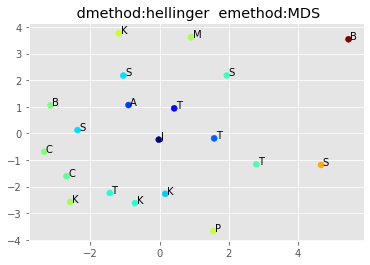

In [16]:
q.plot_embedding(embedding,mdpdfcol)